### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [40]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2017.csv')
df = df.iloc[::3, :]
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + " " + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [41]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [42]:
df.tail()

,year,Post
5229,2017,10 Herbs That Treat Anxiety Better Than Drugs ...
5232,2017,7 Effective Ways to Manage Anxiety “People ten...
5235,2017,I Feel Invincible Because I Know I Am Not Peop...
5238,2017,Anxiety At Christmas Over the course of my lif...
5241,2017,not here you told me a million times that you’...


In [43]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [44]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [45]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['simple', 'short', 'technique', 'to', 'beat', 'anxiety', 'often', 'there', 'are', 'worries', 'that', 'occupy', 'our', 'minds', 'for', 'days', 'more', 'often', 'than', 'not', 'we', 'are', 'in', 'fact', 'aware', 'that', 'the', 'anxiety', 'is', 'irrational', 'and', 'we', 'engage', 'in', 'mental', 'conversation', 'with', 'the', 'anxiety', 'trying', 'to', 'replace', 'it', 'with', 'rational', 'thoughts', 've', 'personally', 'found', 'this', 'strategy', 'to', 'be', 'ultimately', 'useless', 'it', 'doesn', 'help', 'in', 'relieving', 'in', 'the', 'anxiety', 'much', 'and', 'doesn', 'prevent', 'anxiety', 'from', 'coming', 'back', 'instead', 'here', 'is', 'simple', 'specific', 'technique', 'to', 'beat', 'anxiety', 'that', 've', 'personally', 'used', 'and', 'found', 'useful', 'note', 'that', 'the', 'while', 'the', 'last', 'point', 'isn', 'in', 'your', 'immediate', 'control', 'technically', 'what', 'you', 'can', 'directly', 'control', 'is', 'what', 'you', 'write', 'down', 'in', 'your', 'test', 'and

In [46]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [47]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [48]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['simple', 'short', 'technique', 'to', 'beat', 'anxiety', 'often', 'there', 'are', 'worries', 'that', 'occupy', 'our', 'minds', 'for', 'days', 'more', 'often', 'than', 'not', 'we', 'are', 'in', 'fact', 'aware', 'that', 'the', 'anxiety', 'is', 'irrational', 'and', 'we', 'engage', 'in', 'mental', 'conversation', 'with', 'the', 'anxiety', 'trying', 'to', 'replace', 'it', 'with', 'rational', 'thoughts', 've', 'personally', 'found', 'this', 'strategy', 'to', 'be', 'ultimately', 'useless', 'it', 'doesn', 'help', 'in', 'relieving', 'in', 'the', 'anxiety', 'much', 'and', 'doesn', 'prevent', 'anxiety', 'from', 'coming', 'back', 'instead', 'here', 'is', 'simple', 'specific', 'technique', 'to', 'beat', 'anxiety', 'that', 've', 'personally', 'used', 'and', 'found', 'useful', 'note', 'that', 'the', 'while', 'the', 'last', 'point', 'isn', 'in', 'your', 'immediate', 'control', 'technically', 'what', 'you', 'can', 'directly', 'control', 'is', 'what', 'you', 'write', 'down', 'in', 'your', 'test', 'and'

In [49]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [50]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [57]:
# data_words_nostops = remove_stopwords(data_words)
# print("1")
# data_words_bigrams = make_bigrams(data_words_nostops)
# print("2")

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm")

# # 1. Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print("3")

# # 2. Create Dictionary needed for topic modelling
# id2word = corpora.Dictionary(data_lemmatized)
# print("4")

# # 3. Create Corpus
# texts = data_lemmatized

# # 4. Term Document Frequency and Create a bag of words
# bow_corpus = bow(dictionary=id2word, processed_docs=texts)
# print("5")

# # 5. Calculate low_tfidf_words
# # Keep only words with tfidf ranking <= x * len(dictionary)
# x = 0.2
# total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
# print("6")
# sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
# print("7")
# low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)
# print("8")

# # 6. Filter out least frequently used words
# no_below = 0.02
# keep_n = 10000
# dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
#                                                  no_below, keep_n)
# print("9")

# # 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
# dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)
# print("10")

# # 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# # created after least frequently and most commonly used words were filtered out.
# corpus = bow(dict_tfidf_filtered, texts)
# print("11")

# # View
# [[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
num_topics = 26
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=26,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [58]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(8,
  '0.146*"recovery" + 0.124*"recover" + 0.120*"magic" + 0.094*"knee" + '
  '0.078*"red" + 0.077*"scar" + 0.073*"land" + 0.071*"noise" + 0.044*"third" + '
  '0.042*"hole"'),
 (16,
  '0.275*"meditation" + 0.209*"practice" + 0.080*"meditate" + 0.055*"present" '
  '+ 0.043*"combine" + 0.036*"morning" + 0.032*"mental" + 0.027*"habit" + '
  '0.021*"creativity" + 0.020*"clarity"'),
 (13,
  '0.136*"hair" + 0.079*"girl" + 0.076*"man" + 0.073*"air" + 0.051*"film" + '
  '0.047*"cut" + 0.042*"suicide" + 0.031*"tear" + 0.029*"dry" + 0.027*"nail"'),
 (21,
  '0.157*"dog" + 0.147*"water" + 0.066*"master" + 0.057*"shoe" + 0.055*"warm" '
  '+ 0.051*"animal" + 0.048*"color" + 0.041*"black" + 0.041*"cat" + '
  '0.034*"object"'),
 (19,
  '0.428*"eat" + 0.235*"food" + 0.189*"com" + 0.029*"ok" + 0.028*"healthy" + '
  '0.013*"unhealthy" + 0.009*"mental" + 0.007*"final" + 0.003*"city" + '
  '0.002*"consume"'),
 (0,
  '0.076*"art" + 0.072*"creative" + 0.052*"story" + 0.038*"company" + '
  '0.038*"artist" +

In [59]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.390756730437124


In [60]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dict_tfidf_filtered, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.35260745372705204


In [61]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [62]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,20.0,0.3947,"social, level, high, exercise, effect, increas...","[simple, short, technique, beat, anxiety, ofte..."
1,1,20.0,0.3664,"social, level, high, exercise, effect, increas...","[self, care, anxiety, panic, day, friend, tell..."
2,2,6.0,0.4149,"job, drink, phone, pay, normal, money, car, bu...","[stop, drink, alcohol, first, ever, blog_post,..."
3,3,7.0,0.5776,"break, realize, probably, story, house, decide...","[new, tonight, look, page, totally, empty, mom..."
4,4,15.0,0.4582,"child, woman, school, parent, kid, young, moth...","[go, university, mental, disorder, suffer, men..."


In [63]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,20.0,0.3947,"social, level, high, exercise, effect, increas...","[simple, short, technique, beat, anxiety, ofte..."
1,1,20.0,0.3664,"social, level, high, exercise, effect, increas...","[self, care, anxiety, panic, day, friend, tell..."
2,2,6.0,0.4149,"job, drink, phone, pay, normal, money, car, bu...","[stop, drink, alcohol, first, ever, blog_post,..."
3,3,7.0,0.5776,"break, realize, probably, story, house, decide...","[new, tonight, look, page, totally, empty, mom..."
4,4,15.0,0.4582,"child, woman, school, parent, kid, young, moth...","[go, university, mental, disorder, suffer, men..."
...,...,...,...,...,...
1743,1743,23.0,0.2386,"mental_health, health, medication, issue, supp...","[herb, treat, anxiety, well, drug, many, exper..."
1744,1744,20.0,0.2977,"social, level, high, exercise, effect, increas...","[effective, way, manage, anxiety, people, tend..."
1745,1745,7.0,0.4326,"break, realize, probably, story, house, decide...","[feel, invincible, know, people, tell, tough, ..."
1746,1746,7.0,0.2786,"break, realize, probably, story, house, decide...","[anxiety, christmas, course, life, unwilling, ..."


In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

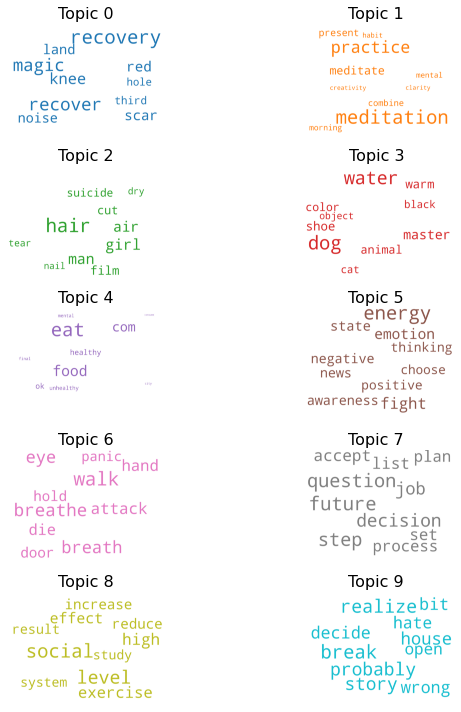

In [64]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [65]:
df_dominant_topic.to_csv("Medium2017.csv")

In [67]:
topic_words = []
for i in range(num_topics):
    tt = lda_model.get_topic_terms(i,10)
    topic_words.append([id2word[pair[0]] for pair in tt])
for i in range(0,num_topics):
    print(topic_words[i])    
df2=pd.DataFrame({'Year':[],'Source':[],'Topic_ID':[],'Most_freq_words':[]})
df2['Most_freq_words']=topic_words
df2 = df2.assign(Year=2014)
df2 = df2.assign(Source='Medium')
print(df2.shape)
ls=[]
for i in range(0,num_topics):
    ls.append(i)
df2['Topic_ID']=ls
df2

['art', 'creative', 'story', 'company', 'artist', 'career', 'coach', 'culture', 'speak', 'review']
['question', 'emotion', 'thinking', 'truth', 'crisis', 'pattern', 'idea', 'behavior', 'external', 'uncertainty']
['book', 'american', 'existence', 'fat', 'author', 'diet', 'low', 'confront', 'percent', 'like']
['future', 'step', 'question', 'decision', 'job', 'accept', 'set', 'list', 'process', 'plan']
['morning', 'darkness', 'light', 'dark', 'glass', 'bed', 'wake', 'dance', 'useless', 'awake']
['mindfulness', 'app', 'rich', 'project', 'email', 'technology', 'inspire', 'communicate', 'platform', 'podcast']
['job', 'drink', 'phone', 'pay', 'normal', 'money', 'car', 'business', 'month', 'horrible']
['break', 'realize', 'probably', 'story', 'house', 'decide', 'wrong', 'bit', 'hate', 'open']
['recovery', 'recover', 'magic', 'knee', 'red', 'scar', 'land', 'noise', 'third', 'hole']
['energy', 'fight', 'emotion', 'state', 'awareness', 'negative', 'news', 'thinking', 'positive', 'choose']
['shit'

,Year,Source,Topic_ID,Most_freq_words
0,2014,Medium,0,"[art, creative, story, company, artist, career..."
1,2014,Medium,1,"[question, emotion, thinking, truth, crisis, p..."
2,2014,Medium,2,"[book, american, existence, fat, author, diet,..."
3,2014,Medium,3,"[future, step, question, decision, job, accept..."
4,2014,Medium,4,"[morning, darkness, light, dark, glass, bed, w..."
5,2014,Medium,5,"[mindfulness, app, rich, project, email, techn..."
6,2014,Medium,6,"[job, drink, phone, pay, normal, money, car, b..."
7,2014,Medium,7,"[break, realize, probably, story, house, decid..."
8,2014,Medium,8,"[recovery, recover, magic, knee, red, scar, la..."
9,2014,Medium,9,"[energy, fight, emotion, state, awareness, neg..."


In [69]:
df2.to_csv("topic_words_m2017.csv")

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, 
                                                id2word=dictionary, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [54]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=50, step=6)


range(2, 50, 6)
[0.23424850409523693, 0.25420340968506827, 0.25289411311817217, 0.24647779856989965, 0.25540661615087595, 0.25860518617506645, 0.2566455784254831, 0.25446661339436233]


(8, 0.019954905589831345, 0.25420340968506827)

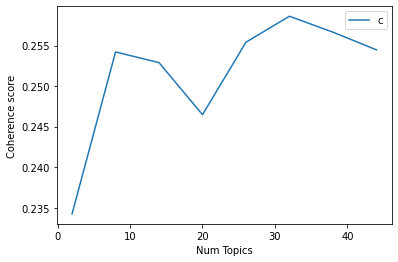

In [56]:
# Show graph
limit=50; start=2; step=6;
x = range(start, limit, step)
print(x)
print(coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)